This file contains the preprocessing and saving the result dataframe to csv.

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\User\AppData\Local\Temp\ipykernel_9904\2023747846.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Download data from kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
# download api token from: https://www.kaggle.com/settings -> and upload here:
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nguyentuannguyen/optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip

In [ ]:
df_train = pd.read_csv('/content/optiver-trading-at-the-close/train.csv')
df_train.shape

# Local

In [2]:
# Replace with your own path
path = 'data/optiver-trading-at-the-close/train.csv'
df_train = pd.read_csv(path)
df_train.shape

(5237980, 17)

# Feature selection and engineering

In [3]:
# float64 type features
columns_to_convert = ['reference_price', 'matched_size', 'far_price', 'near_price',
                      'bid_price', 'bid_size', 'ask_price', 'ask_size',
                      'wap', 'target', 'imbalance_size']
# convert to float32 to save memory
df_train[columns_to_convert] = df_train[columns_to_convert].astype('float32')

df_train.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float32
imbalance_buy_sell_flag      int64
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int64
row_id                      object
dtype: object

Based on data analysis, we found highly skewed datas. Applying Quantile Transformation to follow a normal distribution and drop the original ones.

In [4]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_train['Quantile_imbalance_size'] = quantile_transformer.fit_transform(df_train['imbalance_size'].values.reshape(-1, 1)).flatten()
df_train['Quantile_far_price'] = quantile_transformer.fit_transform(df_train['far_price'].values.reshape(-1, 1)).flatten()
df_train['Quantile_bid_size'] = quantile_transformer.fit_transform(df_train['bid_size'].values.reshape(-1, 1)).flatten()
df_train['Quantile_ask_size'] = quantile_transformer.fit_transform(df_train['ask_size'].values.reshape(-1, 1)).flatten()

# original features
features = ['imbalance_size', 'far_price', 'bid_size', 'ask_size']

# drop features
df_train = df_train.drop(features, axis=1)

In [13]:
# check the nan values
df_train.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
near_price                 2857180
bid_price                      220
ask_price                      220
wap                            220
target                          88
time_id                          0
row_id                           0
Quantile_imbalance_size        220
Quantile_far_price         2894342
Quantile_bid_size                0
Quantile_ask_size                0
dtype: int64

In [5]:
def drop_missing_values(df):
    # drop the missing values of wap
    df = df.dropna(subset=['wap'])
    return df
# drop the missing values of wap
df_train = drop_missing_values(df_train)
df_train.shape

(5237760, 17)

# Create features based on research

In [6]:
%%time

def calc_feature_single_stock(df):
    # Feature of each stock at different time point
    # date_id
    df["date_id_week"] = df["date_id"] % 5  # Day of the week
    df["date_id_seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    # volume is the sum of ask and bid size
    df_train['volume'] = df_train['Quantile_ask_size'] + df_train['Quantile_bid_size']
    df_train['volume_norm'] = (df_train['volume'] - df_train['volume'].mean()) / df_train['volume'].std()
    # The difference between the ask/bid price and the WAP can indicate market efficiency.
    df['spread'] = df['ask_price'] - df['bid_price']
   
    df['mid_price'] = (df['bid_price'] + df['ask_price'])/2
    # product of imbalance size and bid-ask spread
    df["price_pressure"] = df["Quantile_imbalance_size"] * (df["spread"])
    
    # near_price far_price
    df['near_far_ratio'] = df['near_price'] / df['Quantile_far_price']
    df['near_far_imbalance'] = (df['Quantile_far_price'] - df['near_price']) / (df['Quantile_far_price'] + df['near_price'])
   
    
    #The ratio between ask/bid and matched sizes provides insights into market liquidity and order flow:
    # A high ask-to-matched ratio suggests that there are more sellers than buyers at a given price level, 
    # potentially indicating resistance to upward price movement.
    # Conversely, a low ratio implies stronger buying interest and potential support for price increases.
    
    df['ask_mat_ratio'] = df['Quantile_ask_size']/df['matched_size']
    df['bid_mat_ratio'] = df['Quantile_bid_size']/df['matched_size']
    
    # The ratio between the ask/bid price and the reference price provides insights into market sentiment:
    # - Above 1: If the ask/bid price is higher than the reference price, it suggests bullish sentiment. Sellers are demanding a premium.
    # - Below 1: If the ask/bid price is lower than the reference price, it indicates bearish sentiment. Buyers are getting a discount.
    df['ask_ref_ratio'] = df['ask_price']/df['reference_price']
    # imbalance_size matched_size
    df['auction_volume'] = df['Quantile_imbalance_size'] + df['matched_size']
    # relative imbalance between matched and total size
    df["imbalance_ratio"] = (df["Quantile_imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["Quantile_imbalance_size"])
    # cross term 
    df["imbalance_continuous_ratio"] = df['Quantile_imbalance_size'] / df["volume_norm"]
    # the overall level of buying and selling in financial markets
    df['market_activity'] = df['Quantile_bid_size'] * df['bid_price'] + df['Quantile_ask_size'] * df['ask_price']
    # The difference between the ask/bid price and the WAP can indicate market efficiency.
    df['ask_wap_diff'] = df['ask_price'] - df['wap']
    # Accumulative features
    df['imbalance_buy_sell_flag_cumsum'] =  df.groupby(['stock_id','date_id'])['imbalance_buy_sell_flag'].cumsum()
    df['rolling_std_reference_price'] = df.groupby('stock_id')['reference_price'].transform(lambda x: x.rolling(window=54).std())
    df['vwap_reference_price'] = (df['wap'] * df['reference_price']).cumsum() / df['volume_norm'].cumsum()
    # statistical features at different time point
    prices = ["reference_price", "Quantile_far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "Quantile_bid_size", "Quantile_ask_size", "Quantile_imbalance_size"]
    for func in ["mean", "std", "skew", "kurt"]:
            df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
            df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
            
    dummy_cols_list = ['imbalance_buy_sell_flag']
    dummy_names = []
    for col in dummy_cols_list:
        dummy_df = pd.get_dummies(df.loc[:, col], prefix=col, drop_first=True)
        dummy_names += dummy_df.columns.tolist()
        # drop original column
        df = df.drop(col, axis=1)
        df = pd.concat([df, dummy_df], axis=1)
    return df

df_train = calc_feature_single_stock(df_train)
df_train.tail()


CPU times: total: 2.72 s
Wall time: 10.8 s


,stock_id,date_id,seconds_in_bucket,reference_price,matched_size,near_price,bid_price,ask_price,wap,target,...,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1
5237975,195,480,540,1.000317,28280362.0,0.999734,1.000317,1.000434,1.000328,2.310276,...,0.830386,7070091.00,0.416020,14140180.0,-2.449488,2.0,5.999992,4.0,False,False
5237976,196,480,540,1.000643,9187699.0,1.000386,1.000643,1.000900,1.000819,-8.220077,...,0.847850,2296925.50,0.374351,4593849.0,-2.449489,2.0,5.999995,4.0,False,False
5237977,197,480,540,0.995789,12725436.0,0.995789,0.995789,0.995883,0.995797,1.169443,...,0.705909,3181358.25,0.710108,6362718.5,-2.449490,2.0,6.000000,4.0,True,False
5237978,198,480,540,0.999210,94773272.0,0.999210,0.998970,0.999210,0.999008,-1.540184,...,0.809469,23693318.00,0.464552,47386636.0,-2.449490,2.0,5.999999,4.0,False,True
5237979,199,480,540,1.002129,24073678.0,1.001494,1.002129,1.002447,1.002274,-6.530285,...,0.882249,6018420.50,0.293562,12036838.0,-2.449483,2.0,5.999975,4.0,False,False


In [7]:
# select high correlated features
corr_matrix = df_train.corr()
corr_features_to_target = corr_matrix[abs(corr_matrix['target']) > 0.05]['target'].sort_values(ascending=False)
#OVERALL high correlated features
corr_features_to_target

target               1.000000
ask_wap_diff         0.089569
Quantile_ask_size    0.058385
Quantile_bid_size   -0.060342
Name: target, dtype: float64

In [8]:
# select columns which are highly correlated with each other
def get_high_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

to_drop = get_high_correlated_features(df_train, threshold=0.9)

In [20]:
to_drop

['bid_price',
 'ask_price',
 'wap',
 'time_id',
 'volume_norm',
 'mid_price',
 'auction_volume',
 'market_activity',
 'all_prices_mean',
 'all_sizes_mean',
 'all_sizes_std',
 'all_sizes_kurt',
 'imbalance_buy_sell_flag_0']

In [9]:
# drop the highly correlated features
df_train = df_train.drop(to_drop, axis=1)

# Feature Selection

In [10]:
%%time
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

train_df = df_train.drop(columns=['target'])
targets = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(train_df, targets, test_size=0.2, shuffle=False)


seed = 42 # Set the seed

# Initialize the XGBRegressor with desired hyperparameters
bst_xgb = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 50,
    learning_rate = 0.3,
    random_state=seed,
    verbosity=0,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)
selector = RFECV(bst_xgb, min_features_to_select=1, step=5, cv=tscv, verbose=3)
selector = selector.fit(X_train, y_train)

Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.


In [11]:
# Number of selected features
print(selector.n_features_)

# Feature names that were selected, print out the selected features
print(selector.support_)
print(selector.feature_names_in_)
for i in range(len(selector.support_)):
    if selector.support_[i]:
        print(X_train.columns[i])
# plot feature importance



7
[False False  True False False False False False False  True  True False
 False False  True False False False False False  True False False  True
 False False False False False False False  True]
['stock_id' 'date_id' 'seconds_in_bucket' 'reference_price' 'matched_size'
 'near_price' 'row_id' 'Quantile_imbalance_size' 'Quantile_far_price'
 'Quantile_bid_size' 'Quantile_ask_size' 'date_id_week' 'date_id_seconds'
 'volume' 'spread' 'price_pressure' 'near_far_ratio' 'near_far_imbalance'
 'ask_mat_ratio' 'bid_mat_ratio' 'ask_ref_ratio' 'imbalance_ratio'
 'imbalance_continuous_ratio' 'ask_wap_diff'
 'imbalance_buy_sell_flag_cumsum' 'rolling_std_reference_price'
 'vwap_reference_price' 'all_prices_std' 'all_prices_skew'
 'all_sizes_skew' 'all_prices_kurt' 'imbalance_buy_sell_flag_1']
seconds_in_bucket
Quantile_bid_size
Quantile_ask_size
spread
ask_ref_ratio
ask_wap_diff
imbalance_buy_sell_flag_1


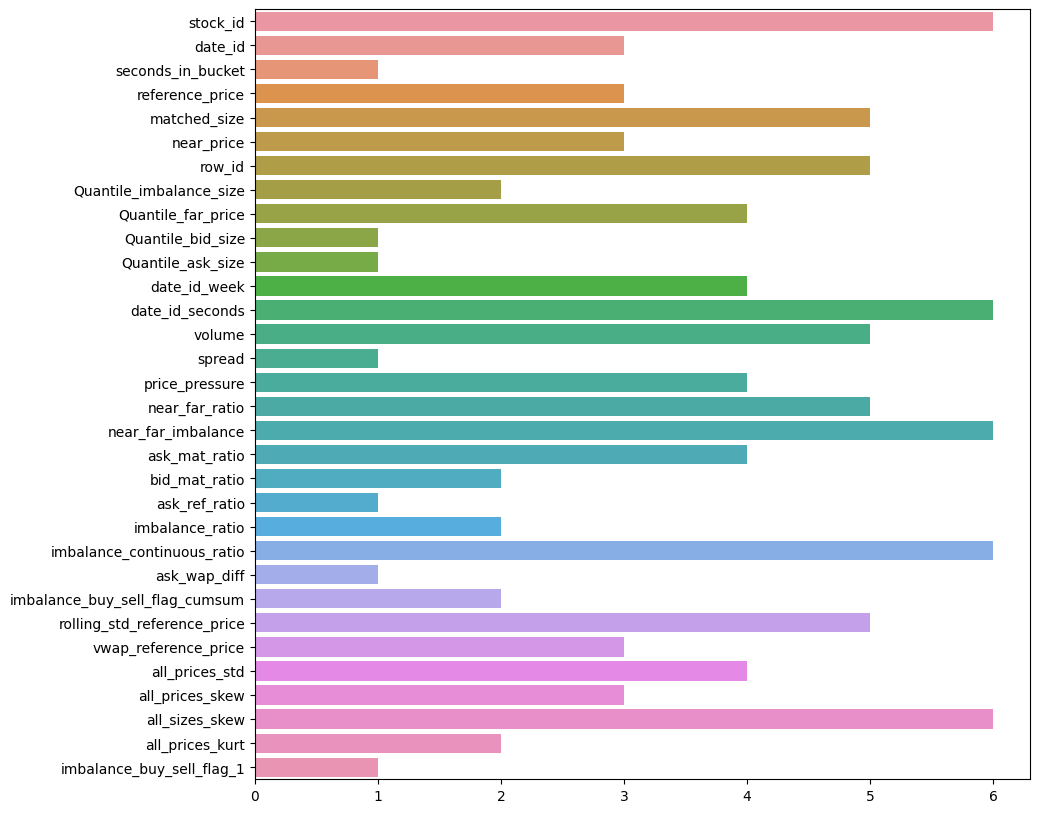

In [12]:
# plot feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x=selector.ranking_, y=X_train.columns)
plt.show()





In [18]:

selected_features = X_train.columns[selector.support_]

selected_features

Index(['seconds_in_bucket', 'Quantile_bid_size', 'Quantile_ask_size', 'spread',
       'ask_ref_ratio', 'ask_wap_diff', 'imbalance_buy_sell_flag_1'],
      dtype='object')

In [19]:
# add the necessary features

selected_features =  ['stock_id', 'date_id','target', 'seconds_in_bucket', 'Quantile_bid_size', 'Quantile_ask_size', 'spread',
       'ask_ref_ratio', 'ask_wap_diff', 'imbalance_buy_sell_flag_1']

In [20]:
df = df_train[selected_features]

# save the selected features
df.to_csv('selected_features.csv', index=False)